# ロボットの移動ばらつきパラメータを求める

In [2]:
import sys
sys.path.append('../src')
import importlib

import worlds
import maps
import numpy as np
import robots
import sensors
import agents
import landmarks
import estimators
import particles

def reload():
    importlib.reload(worlds)
    importlib.reload(maps)
    importlib.reload(robots)
    importlib.reload(sensors)
    importlib.reload(agents)
    importlib.reload(estimators)
    importlib.reload(particles)

<IPython.core.display.Javascript object>


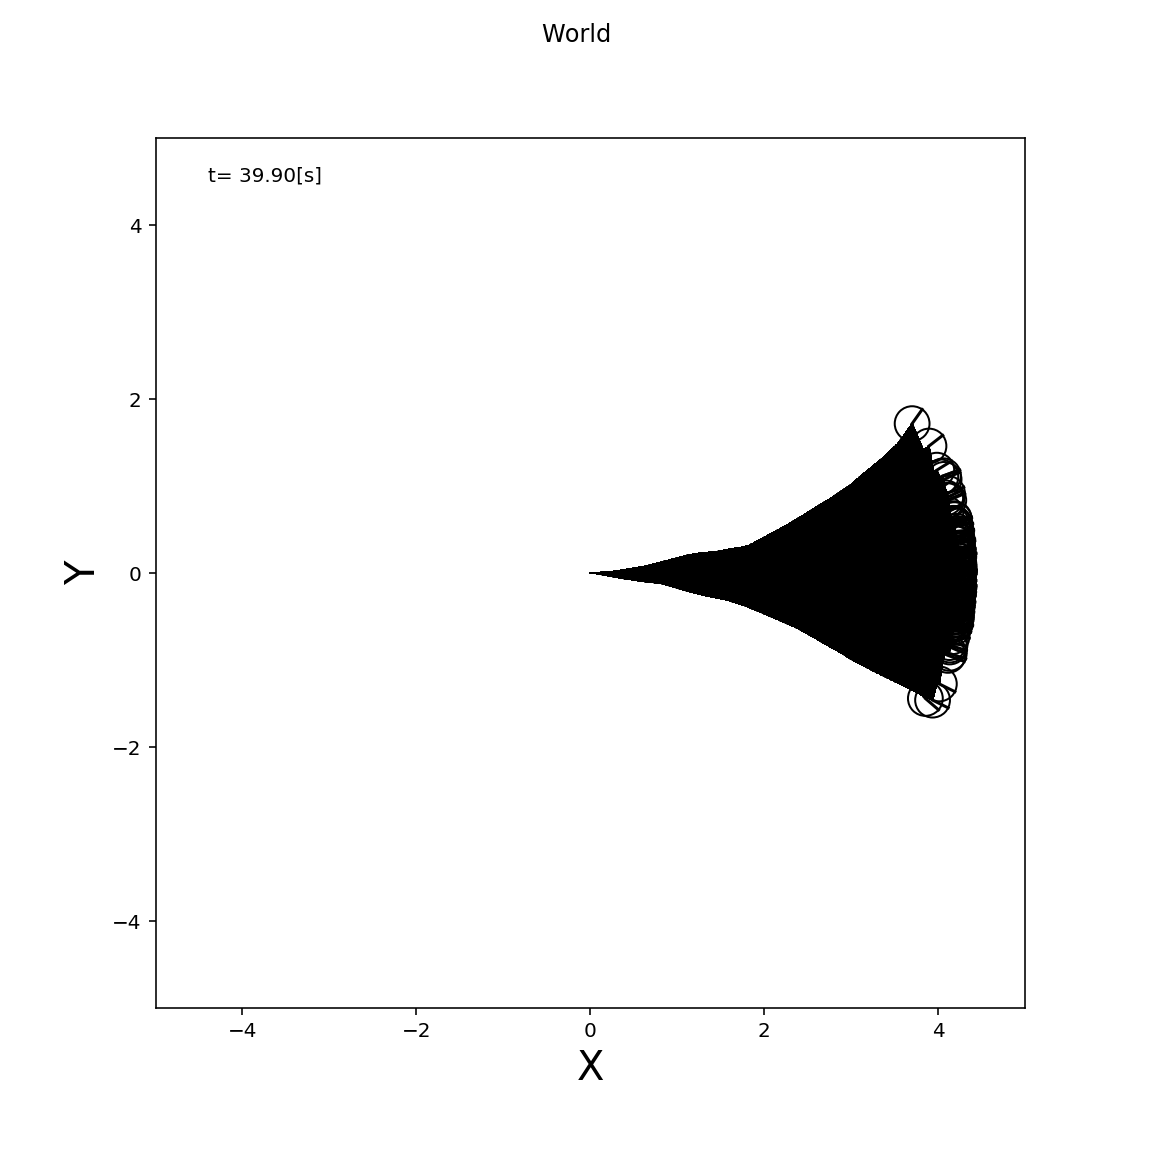

In [3]:
# ロボットを
# 0.1[m/s]で
# 4.0[m]走らせて
# 移動後の姿勢を記録する
# それを100回する
reload()

import copy

world = worlds.World(40., 0.1, debuggable=True)

initial_pose = np.array([0.,0.,0.])

robot = robots.Robot(initial_pose, sensor=None, agent=agents.Agent(0.1, 0.0))
robots_ = []

for i in range(100):
    # 大本のロボットは使い回す
    # 道のりのばらつき以外のばらつきを統一するため
    copy_r = copy.copy(robot)
    copy_r.distance_until_noise = copy_r.noise_pdf.rvs()
    world.append(copy_r)
    robots_.append(copy_r)
    
world.draw()

In [4]:
# ↑の処理はめっちゃ時間かかかる
import math
import pandas as pd

# 距離rと姿勢theta
poses = pd.DataFrame(
    [[math.sqrt(r.pose[0]**2 + r.pose[1]**2), r.pose[2]] for r in robots_],
    columns=['r', 'theta'])
poses.transpose()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
r,4.239771,4.208020,4.190177,4.239243,4.237426,4.228931,4.243013,4.243443,4.210396,4.228807,...,4.21724,4.230296,4.245000,4.247133,4.241842,4.239607,4.205442,4.229570,4.186246,4.220344
theta,0.017778,0.154461,0.397420,-0.060479,-0.091691,-0.205649,-0.074649,-0.027459,-0.410634,-0.356332,...,0.43041,-0.248675,0.107409,-0.197016,-0.108380,0.131463,-0.297092,0.148145,0.424169,0.331454


In [5]:
# 姿勢のばらつきと距離の平均から，直進が回転に与えるばらつきを求める

print(poses['theta'].var())
print(poses['r'].mean())

# 分散の大きさが距離に比例するなら (var / mean)^(1/2)が1[m]あたりの直進が回転に与える標準偏差になる
sigma_omega_nu = poses['theta'].var() / poses['r'].mean()
math.sqrt(sigma_omega_nu)

0.06826070936370221
4.228696571319862


0.1270521845516347

<IPython.core.display.Javascript object>


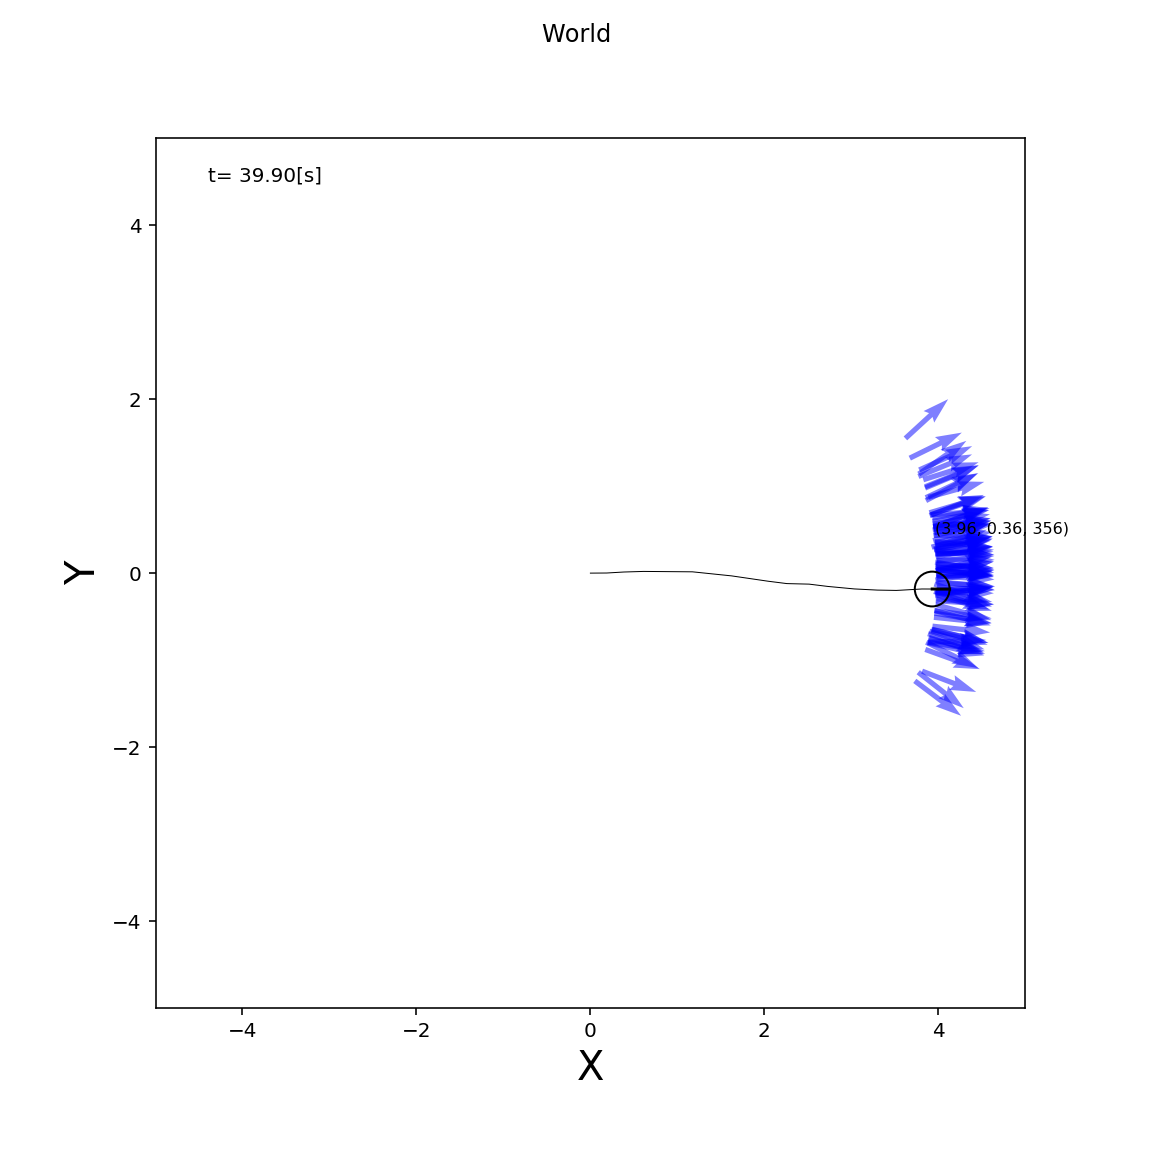

In [7]:
# 得られた値でパーティクルを動かしてみる
# さっきのロボット100台シミュレーションの結果と似ているのでは

world = worlds.World(40., 0.1, debuggable=False)
m = maps.Map()
initial_pose = np.array([0.,0.,0.])
# on以外は小さな値にしておく
estimator = estimators.Mcl(
    m, initial_pose, 100,
    motion_noise_stds={'nn':0.001, 'no': 0.001, 'on': 0.127, 'oo': 0.001})
straight = agents.EstimationAgent(
    0.1, 0.1, 0., estimator=estimator)

robot = robots.Robot(initial_pose, sensor=None, agent=straight)
world.append(robot)
    
world.draw()

<IPython.core.display.Javascript object>


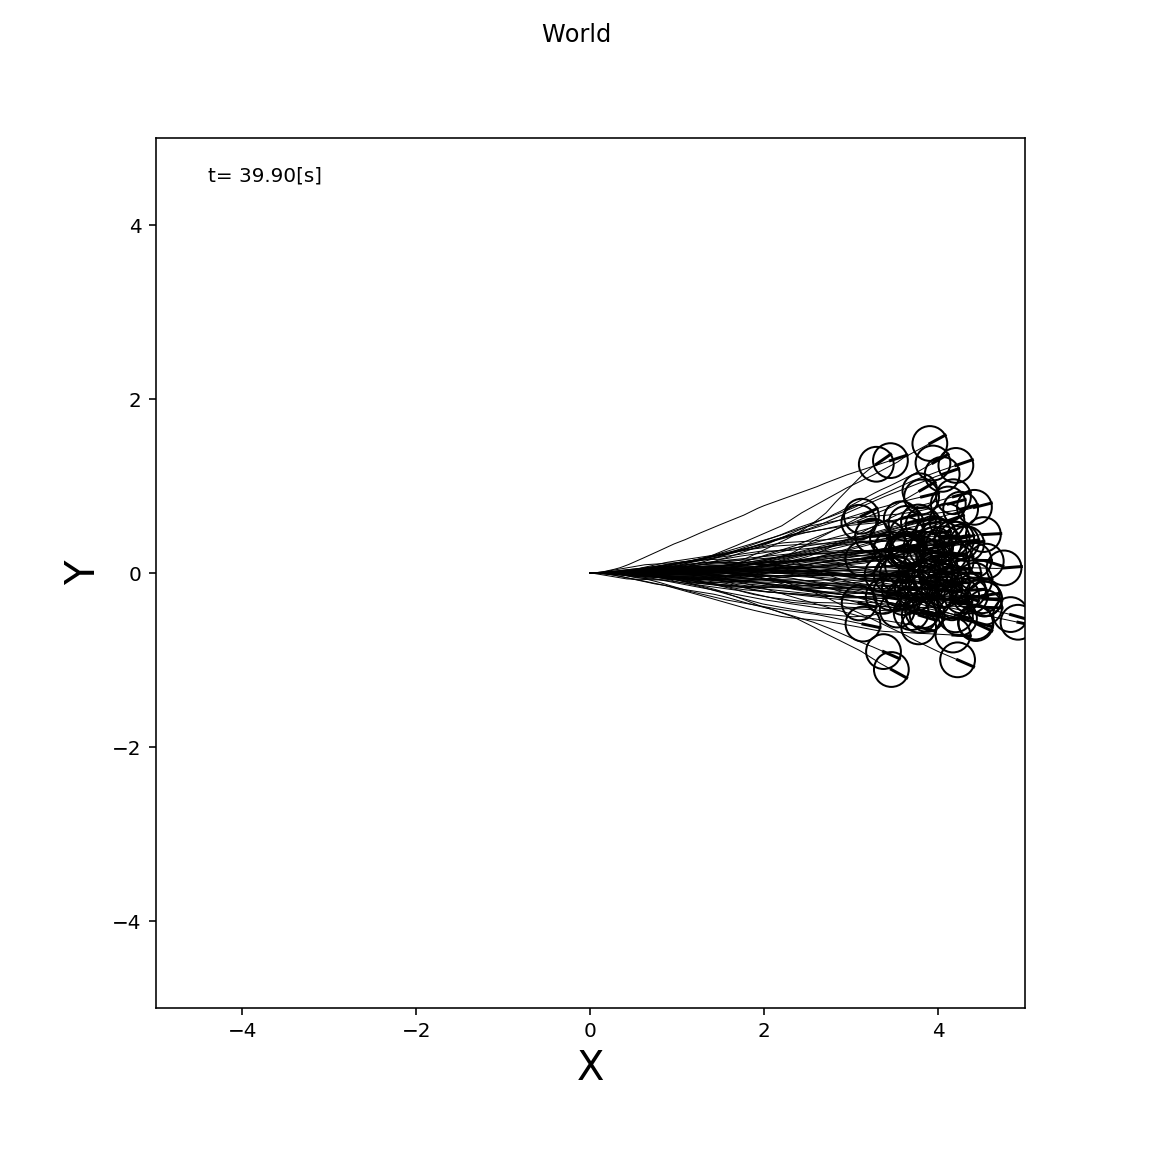

In [8]:
# 次はバイアスの影響を正規分布に当てはめる

world = worlds.World(40., 0.1, debuggable=False)

initial_pose = np.array([0.,0.,0.])


robots_ = []

for i in range(100):
    robot = robots.Robot(initial_pose, sensor=None, agent=agents.Agent(0.1, 0.0))
    world.append(robot)
    robots_.append(robot)
    
world.draw()

In [9]:
# 距離rと姿勢theta
poses = pd.DataFrame(
    [[math.sqrt(r.pose[0]**2 + r.pose[1]**2), r.pose[2]] for r in robots_],
    columns=['r', 'theta'])
poses.transpose()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
r,4.481478,3.280249,4.201385,4.030674,4.285507,4.490927,3.526189,3.538290,3.714658,4.430049,...,4.026158,4.330153,4.188403,4.208572,4.147240,4.141716,4.088013,3.875799,3.644494,3.637720
theta,-0.427346,0.056424,0.254891,-0.014675,-0.266450,0.245686,0.604534,0.260506,-0.039762,0.098764,...,-0.081966,0.234705,0.177520,-0.075874,0.546108,0.038599,0.131266,0.184325,0.021095,0.288275


In [10]:
# 直進が直進に与えるばらつきの標準偏差
r_mean = poses['r'].mean()
r_var = poses['r'].var()
sigma_nu_nu = math.sqrt(r_var / r_mean)
print(sigma_nu_nu)

0.20111405632841708


<IPython.core.display.Javascript object>


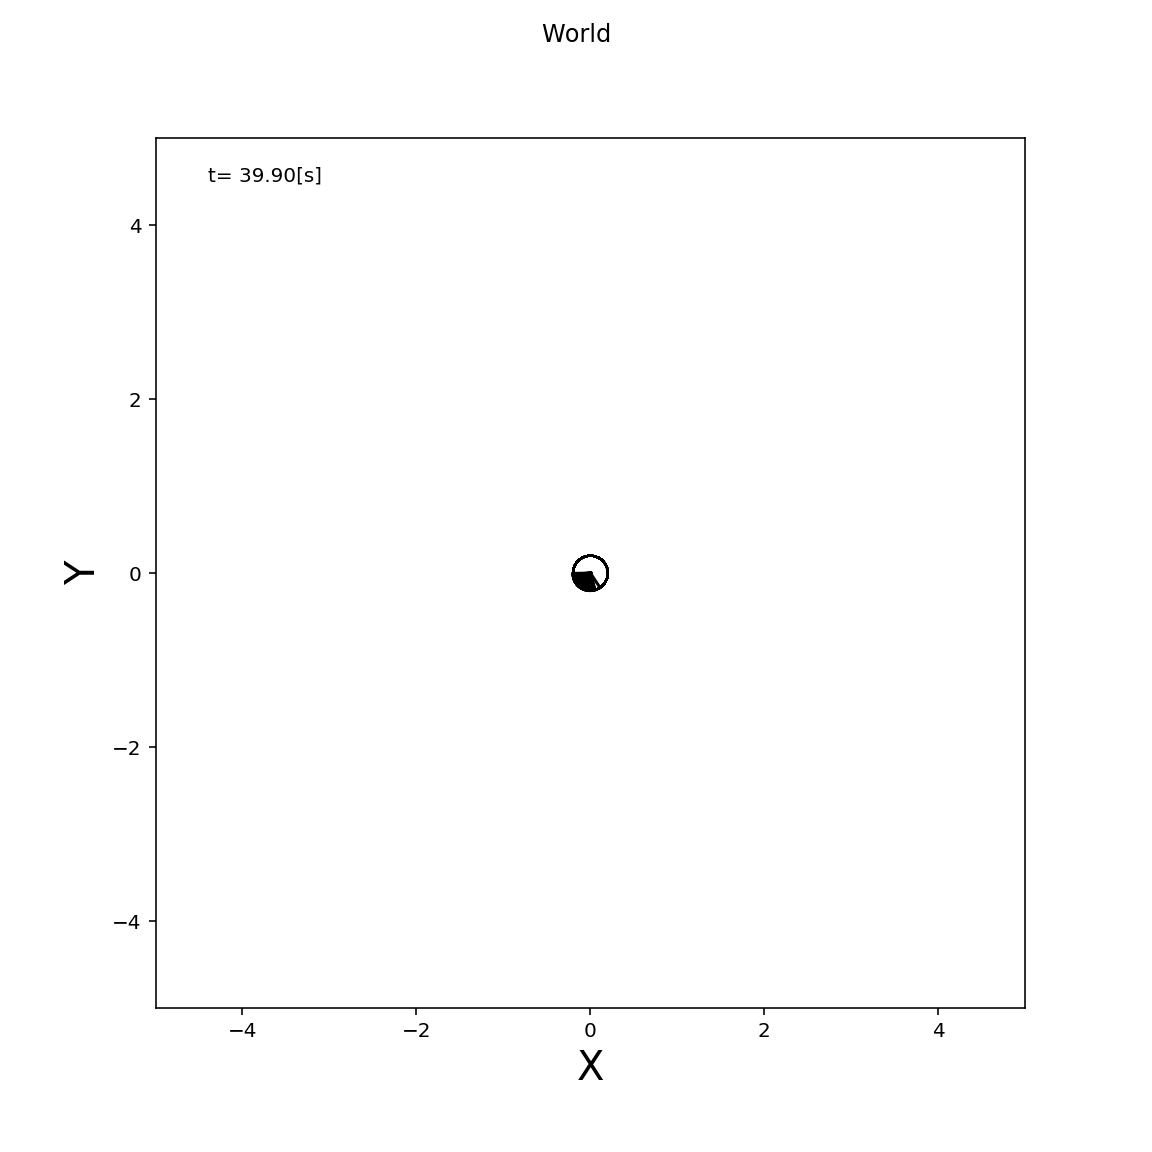

In [11]:
# 回転が回転にあたえるばらつきを求める
world = worlds.World(40.0, 0.1)  

initial_pose = np.array([0, 0, 0]).T
robots_ = []

for i in range(100):
    # 回転のみに指令が当たられたAgent
    r = robots.Robot(initial_pose, sensor=None, agent=agents.Agent(0.0, 0.1)) 
    world.append(r)
    robots_.append(r)

world.draw()

In [12]:
# 距離rと姿勢theta
poses = pd.DataFrame(
    [[math.sqrt(r.pose[0]**2 + r.pose[1]**2), r.pose[2]] for r in robots_],
    columns=['r', 'theta'])
poses.transpose()

# 回転が回転にあたえるばらつきの標準偏差
theta_mean = poses['theta'].mean()
theta_var = poses['theta'].var()
sigma_omega_omega = math.sqrt(theta_var / theta_mean)
print(sigma_omega_omega)

0.2274340845805776


<IPython.core.display.Javascript object>


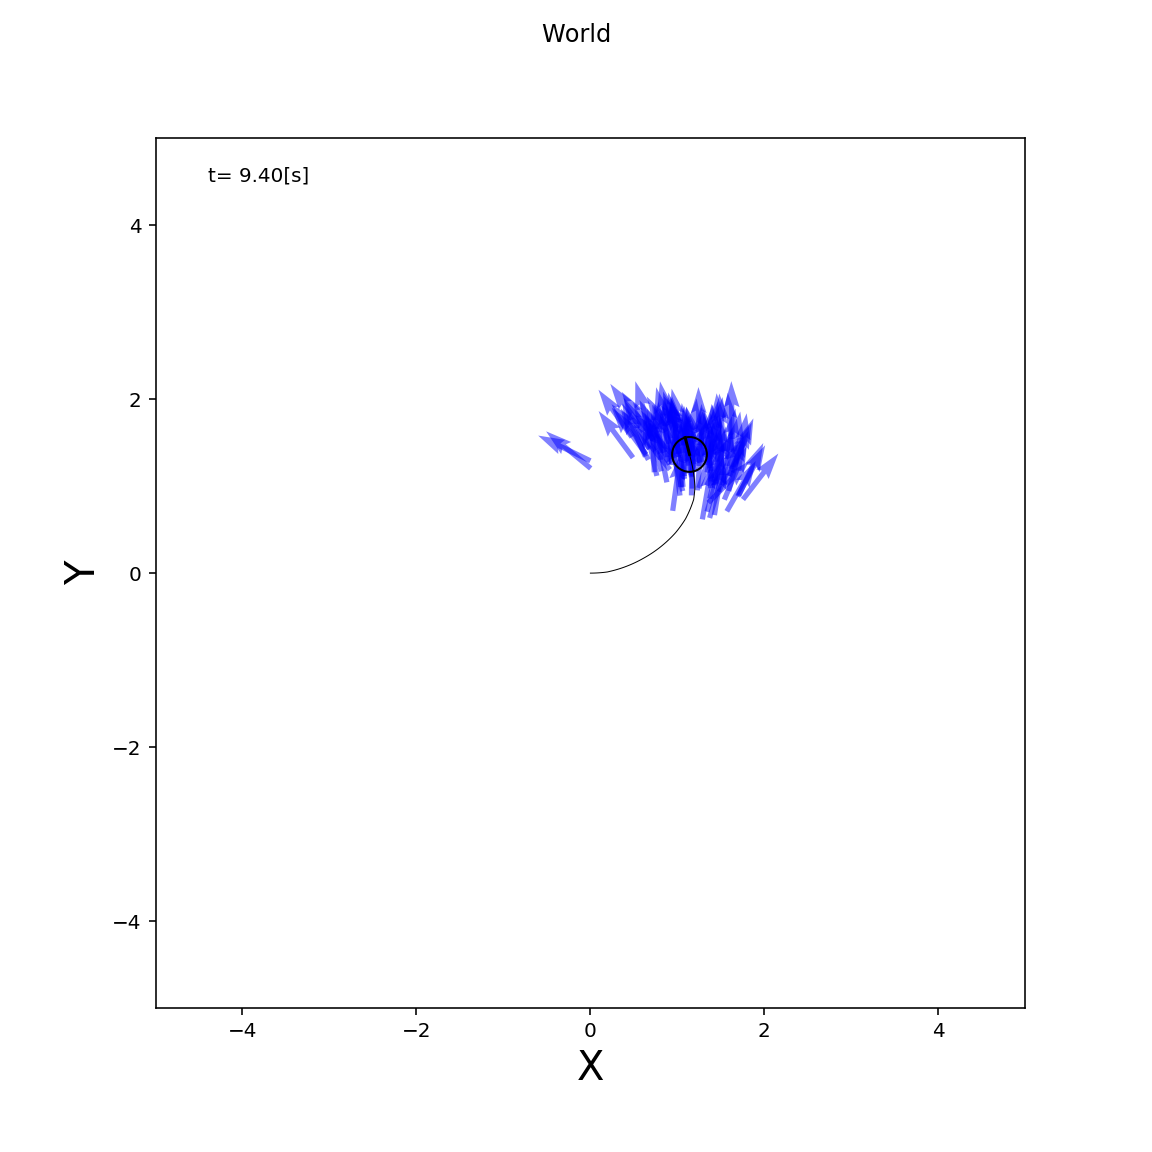

In [47]:
# このパラメータを使ってパーティクルを動かす
reload()
world = worlds.World(30., 0.1, debuggable=False)

initial_pose = np.array([0.,0.,0.])
# on以外は小さな値にしておく
estimator = estimators.Mcl(initial_pose, 100)
circling = agents.EstimationAgent(
    0.1, 0.2, 10./180.*np.pi, estimator=estimator)

robot = robots.Robot(initial_pose, sensor=None, agent=circling)
world.append(robot)
    
world.draw()

## まとめ

- $\sigma_{\nu \nu} = 0.253$
- $\sigma_{\nu \omega} = 0$
- $\sigma_{\omega \nu} = 0.115$
- $\sigma_{\omega \omega} = 0.226$

$\sigma_{\nu \omega} = 0$なのは，回転が直進へ与えるノイズを設定していないため